# Applying $k$-means to Students' Dropout and Academic Success
### For CAP 4770 - Knowledge Disc. & Data Mining, Project 1

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline

#### Load and Format Data

In [2]:
# NOTE: Download 'data.csv' from <https://archive.ics.uci.edu/dataset/697>.
full_data = pd.read_table(
    "data.csv",
    delimiter=";",
    index_col=False,
    low_memory=False,
    dtype={
        "Marital status": "category",
        "Application mode": "category",
        "Course": "category",
        "Daytime/evening attendance\t": "category",
        "Previous qualification": "category",
        "Nacionality": "category",
        "Mother's qualification": "category",
        "Father's qualification": "category",
        "Mother's occupation": "category",
        "Father's occupation": "category",
        "Displaced": "bool",
        "Educational special needs": "bool",
        "Debtor": "bool",
        "Tuition fees up to date": "bool",
        "Gender": "category",
        "Scholarship holder": "bool",
        "International": "bool",
        "Target": "category",
    },
)

# Fix column names.
full_data = full_data.rename(
    columns={
        "Daytime/evening attendance\t": "Daytime/evening attendance",
        "Nacionality": "Nationality",
    },
    errors="raise",
)

In [3]:
# Assign human-readable names to (some) categories.
full_data["Marital status"] = full_data["Marital status"].cat.rename_categories(
    {
        "1": "Single",
        "2": "Married",
        "3": "Widower",
        "4": "Divorced",
        "5": "De facto union",
        "6": "Legally separated",
    }
)

# TODO: Application mode
# TODO: Course

full_data["Daytime/evening attendance"] = full_data[
    "Daytime/evening attendance"
].cat.rename_categories(
    {
        "1": "Daytime",
        "0": "Evening",
    }
)

# TODO: Previous qualification

full_data["Nationality"] = full_data["Nationality"].cat.rename_categories(
    {
        "1": "PT",
        "2": "DE",
        "6": "ES",
        "11": "IT",
        "13": "NL",
        "14": "GB-ENG",
        "17": "LT",
        "21": "AO",
        "22": "CV",
        "24": "GN",
        "25": "MZ",
        "26": "ST",
        "32": "TR",
        "41": "BR",
        "62": "RO",
        "100": "MD",
        "101": "MX",
        "103": "UA",
        "105": "RU",
        "108": "CU",
        "109": "CO",
    }
)

# TODO: Mother's qualification
# TODO: Father's qualification
# TODO: Mother's occupation
# TODO: Father's occupation

full_data["Gender"] = full_data["Gender"].cat.rename_categories(
    {
        "1": "Male",
        "0": "Female",
    }
)

#### Preview Data

In [4]:
# Show a preview of the data, including all attributes.
full_data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,Single,17,5,171,Daytime,1,122.0,PT,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,Single,15,1,9254,Daytime,1,160.0,PT,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,Single,1,5,9070,Daytime,1,122.0,PT,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,Single,17,2,9773,Daytime,1,122.0,PT,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,Married,39,1,8014,Evening,1,100.0,PT,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
# Get all numerical attributes, and show a preview.
numerical_data = full_data.select_dtypes(include=["int", "float"])
numerical_data.head()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,5,122.0,127.3,20,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,160.0,142.5,19,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,5,122.0,124.8,19,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,2,122.0,119.6,20,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,1,100.0,141.5,45,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


In [6]:
# Show descriptive statistics.
numerical_data.describe()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.727848,132.613314,126.978119,23.265145,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,1.313793,13.188332,14.482001,7.587816,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,0.000000,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,125.000000,117.900000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,133.100000,126.100000,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,2.000000,140.000000,134.800000,25.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,9.000000,190.000000,190.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [7]:
# Try to remove outliers, and display descriptive statistics again.
lof = LocalOutlierFactor()
lof_scores = lof.fit_predict(numerical_data)
assert ((lof_scores == -1) | (lof_scores == +1)).all()
outlier_proportion = np.count_nonzero(lof_scores == -1) / lof_scores.size
print(f"{round(outlier_proportion * 100, 2)}% outliers")
numerical_data = numerical_data[lof_scores == +1]
numerical_data.describe()

1.58% outliers


,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000
mean,1.734497,132.557717,126.867455,23.274690,0.680753,6.241387,8.238861,4.700965,10.666817,0.123335,0.517685,6.211759,8.009417,4.431787,10.212336,0.136656,11.561874,1.223886,0.003539
std,1.318643,13.002207,14.264390,7.607284,2.312296,2.433744,4.063859,3.046114,4.816602,0.595328,1.881337,2.173011,3.893854,2.996753,5.221384,0.689205,2.659760,1.384396,2.267347
min,0.000000,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,125.000000,117.900000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,133.100000,126.100000,20.000000,0.000000,6.000000,8.000000,5.000000,12.310000,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,2.000000,140.000000,134.600000,25.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,9.000000,188.000000,184.400000,70.000000,20.000000,23.000000,36.000000,21.000000,18.875000,8.000000,19.000000,23.000000,28.000000,20.000000,18.571429,8.000000,16.200000,3.700000,3.510000


<Axes: xlabel='Nationality'>

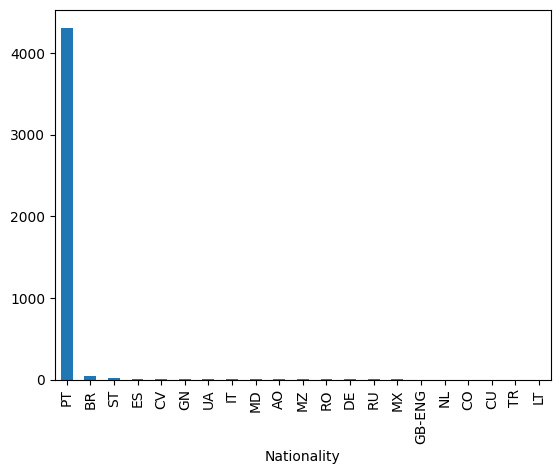

In [8]:
# Create a bar plot showing the frequency of each nationality.
nationality_freq = full_data.value_counts(subset="Nationality")
nationality_freq.plot.bar()

In [9]:
pt_proportion = nationality_freq["PT"] / nationality_freq.sum()
print(f"{round(pt_proportion * 100, 2)}%")

97.51%


Most records are for students from Portugal, which is expected since the research was funded by Portugal.

#### Preprocess Data

In [10]:
# Scale numerical attributes.
scaler = RobustScaler()
scaler.fit(numerical_data)  # NOTE: We don't have a train-test split.
scaled_data = scaler.transform(numerical_data)

In [11]:
# Show a preview of the scaled data.
pd.DataFrame(data=scaled_data, columns=numerical_data.columns).head()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,4.0,-0.740000,0.071856,0.000000,0.0,-3.0,-2.00,-1.666667,-5.129167,0.0,0.0,-3.0,-2.0,-1.25,-4.722581,0.0,-0.066667,0.000000,0.406877
1,0.0,1.793333,0.982036,-0.166667,0.0,0.0,-0.50,0.333333,0.704167,0.0,0.0,0.0,-0.5,0.25,0.567742,0.0,0.622222,-0.739130,0.134670
2,4.0,-0.740000,-0.077844,-0.166667,0.0,0.0,-2.00,-1.666667,-5.129167,0.0,0.0,0.0,-2.0,-1.25,-4.722581,0.0,-0.066667,0.000000,0.406877
3,1.0,-0.740000,-0.389222,0.000000,0.0,0.0,0.00,0.333333,0.466071,0.0,0.0,0.0,0.5,0.00,0.077419,0.0,-0.377778,-0.956522,-0.985673
4,0.0,-2.206667,0.922156,4.166667,0.0,0.0,0.25,0.000000,0.009722,0.0,0.0,0.0,-0.5,0.25,0.309677,0.0,0.622222,-0.739130,0.134670


#### Elbow Method

In [12]:
# Use the elbow method to "guess" the number of clusters.
elbow_k_min = 2
elbow_k_max = 20
elbow_k = [*range(elbow_k_min, elbow_k_max + 1)]
elbow_silhouette = []
elbow_inertia = []
for k in elbow_k:
    k_means = KMeans(n_clusters=k, random_state=1729)
    k_means.fit(scaled_data)
    elbow_silhouette.append(silhouette_score(scaled_data, k_means.labels_))
    elbow_inertia.append(k_means.inertia_)

Text(0, 0.5, 'SSE')

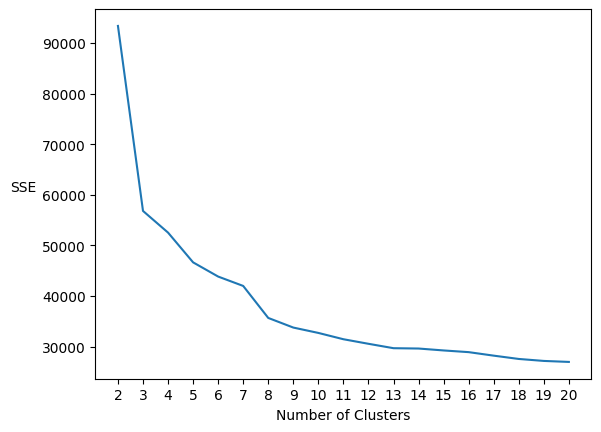

In [13]:
# Plot the inertia for the elbow method.
plt.plot(elbow_k, elbow_inertia)
plt.xticks(elbow_k)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE", horizontalalignment="right", rotation="horizontal")

Text(0, 0.5, 'Silhouette Coefficient')

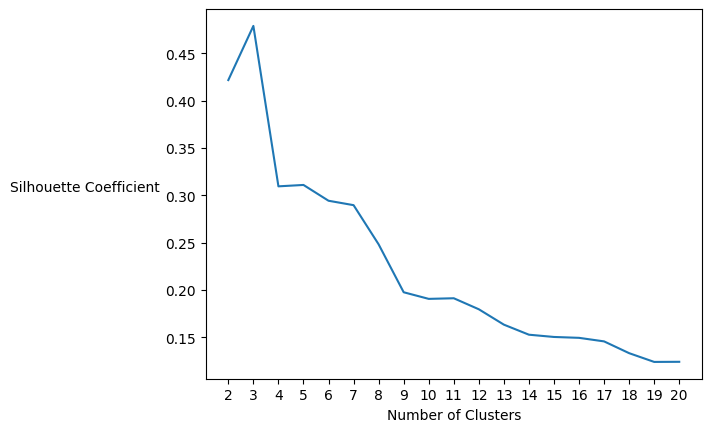

In [14]:
# Plot the silhouette coefficient for the elbow method.
plt.plot(elbow_k, elbow_silhouette)
plt.xticks(elbow_k)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient", horizontalalignment="right", rotation="horizontal")

#### Cluster Data

In [15]:
# Train two models using two different values of 'k'.
# NOTE: k-means uses (squared) Euclidean distance, which can only be sensibly
# calculated when all attributes are numerical.
models = [
    KMeans(n_clusters=3, random_state=1729),
    KMeans(n_clusters=6, random_state=1729),
]
for model in models:
    model.fit(scaled_data)

In [16]:
# Show the inertia/SSE and the silhouette coefficient for each model.
silhouette_coeffs = [silhouette_score(scaled_data, model.labels_) for model in models]
print(f"SSE: {models[0].inertia_} (k=3) vs. {models[1].inertia_} (k=6)")
print(f"Silhouette: {silhouette_coeffs[0]} (k=3) vs. {silhouette_coeffs[1]} (k=6)")

SSE: 56815.037072270745 (k=3) vs. 43842.45864389582 (k=6)
Silhouette: 0.47900010990570085 (k=3) vs. 0.2942685074374451 (k=6)


In [17]:
# Show a preview of cluster assignments for model one.
clustered_data = pd.DataFrame(data=scaled_data, columns=numerical_data.columns)
clustered_data.insert(loc=0, column="Cluster", value=models[0].labels_)
clustered_data.head()

,Cluster,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0,4.0,-0.740000,0.071856,0.000000,0.0,-3.0,-2.00,-1.666667,-5.129167,0.0,0.0,-3.0,-2.0,-1.25,-4.722581,0.0,-0.066667,0.000000,0.406877
1,1,0.0,1.793333,0.982036,-0.166667,0.0,0.0,-0.50,0.333333,0.704167,0.0,0.0,0.0,-0.5,0.25,0.567742,0.0,0.622222,-0.739130,0.134670
2,0,4.0,-0.740000,-0.077844,-0.166667,0.0,0.0,-2.00,-1.666667,-5.129167,0.0,0.0,0.0,-2.0,-1.25,-4.722581,0.0,-0.066667,0.000000,0.406877
3,1,1.0,-0.740000,-0.389222,0.000000,0.0,0.0,0.00,0.333333,0.466071,0.0,0.0,0.0,0.5,0.00,0.077419,0.0,-0.377778,-0.956522,-0.985673
4,1,0.0,-2.206667,0.922156,4.166667,0.0,0.0,0.25,0.000000,0.009722,0.0,0.0,0.0,-0.5,0.25,0.309677,0.0,0.622222,-0.739130,0.134670


In [18]:
# Show a preview of cluster assignments for model two.
clustered_data = pd.DataFrame(data=scaled_data, columns=numerical_data.columns)
clustered_data.insert(loc=0, column="Cluster", value=models[1].labels_)
clustered_data.head()

,Cluster,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,5,4.0,-0.740000,0.071856,0.000000,0.0,-3.0,-2.00,-1.666667,-5.129167,0.0,0.0,-3.0,-2.0,-1.25,-4.722581,0.0,-0.066667,0.000000,0.406877
1,1,0.0,1.793333,0.982036,-0.166667,0.0,0.0,-0.50,0.333333,0.704167,0.0,0.0,0.0,-0.5,0.25,0.567742,0.0,0.622222,-0.739130,0.134670
2,3,4.0,-0.740000,-0.077844,-0.166667,0.0,0.0,-2.00,-1.666667,-5.129167,0.0,0.0,0.0,-2.0,-1.25,-4.722581,0.0,-0.066667,0.000000,0.406877
3,1,1.0,-0.740000,-0.389222,0.000000,0.0,0.0,0.00,0.333333,0.466071,0.0,0.0,0.0,0.5,0.00,0.077419,0.0,-0.377778,-0.956522,-0.985673
4,0,0.0,-2.206667,0.922156,4.166667,0.0,0.0,0.25,0.000000,0.009722,0.0,0.0,0.0,-0.5,0.25,0.309677,0.0,0.622222,-0.739130,0.134670


In [19]:
# Show the centroid of each cluster for model one.
pd.DataFrame(
    data=models[0].cluster_centers_,
    columns=numerical_data.columns,
)

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0.596065,-0.048573,0.009717,0.987847,0.023148,-0.781829,-0.806134,-1.512346,-4.195346,0.216435,0.004630,-0.751157,-1.018808,-1.241030,-4.614464,0.251157,0.112397,-0.035326,-0.162229
1,0.820688,-0.027839,0.045827,0.349850,0.199752,0.081604,0.127207,0.091566,0.187893,0.083308,0.146175,0.121555,0.147879,0.041189,0.182358,0.100341,0.104897,-0.092141,-0.071279
2,0.126437,-0.097880,0.167504,1.506386,8.808429,3.591954,2.090996,2.210728,0.142009,0.310345,6.812261,2.749042,1.582375,1.228927,0.183969,0.206897,0.042401,-0.020490,-0.093787


In [20]:
# Show the centroid of each cluster for model two.
pd.DataFrame(
    data=models[1].cluster_centers_,
    columns=numerical_data.columns,
)

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0.230357,-0.175071,-0.071974,2.195833,2.589286e-01,-0.101786,0.452679,-0.466667,-0.156530,0.164286,1.589286e-01,-0.123214,0.226339,-0.583929,-1.602203,2.910714e-01,0.123175,-0.084627,-0.177282
1,0.939394,0.005926,0.061572,-0.000180,1.107504e-01,0.081349,0.058892,0.137807,0.230864,0.073593,6.601732e-02,0.135642,0.108045,0.084957,0.257054,7.900433e-02,0.102004,-0.088839,-0.055533
2,0.166667,-0.178074,0.018230,1.781481,1.266667e+01,5.205556,2.927778,3.311111,0.024732,0.388889,1.088889e+01,3.955556,2.055556,1.894444,0.111942,2.777778e-01,0.209383,0.039130,-0.386024
3,0.603482,-0.158414,-0.147268,1.293037,6.106227e-15,-0.209865,-0.753385,-1.662798,-5.096123,0.294004,3.868472e-03,-0.155706,-0.963250,-1.235977,-4.551744,2.940039e-01,0.098431,-0.034143,-0.141554
4,0.129310,-0.171695,0.177137,1.346264,5.913793e+00,2.340517,1.438578,1.344828,0.162933,0.228448,4.310345e+00,1.821121,1.129310,0.733836,0.181209,1.551724e-01,0.014655,-0.048538,0.023046
5,0.590164,0.338616,0.563496,0.032787,-1.554312e-15,-2.983607,-1.991803,-1.666667,-5.129167,0.005464,-6.661338e-16,-2.972678,-1.994536,-1.250000,-4.722581,-2.775558e-16,0.120340,-0.078403,-0.213177


#### Visualize Clusters

This is tricky because our dataset is very high-dimensional (19 numerical attributes!), so depending on which attributes we visualize, the clusters may appear less separated than they actually are.

In [21]:
# Based on: <https://bpostance.github.io/posts/clustering-mixed-data/>.


# Plot a single cluster.
def plot_cluster(model, ax, x_axis, y_axis, cluster):
    in_cluster = model.labels_ == cluster
    ax.scatter(
        x=numerical_data[in_cluster][x_axis],
        y=numerical_data[in_cluster][y_axis],
        label=f"Cluster {cluster}",
    )


# Plot all centroids.
def plot_centroids(model, ax, x_axis, y_axis):
    x_axis_index = numerical_data.columns.get_loc(x_axis)
    y_axis_index = numerical_data.columns.get_loc(y_axis)
    centroid = scaler.inverse_transform(model.cluster_centers_)
    ax.scatter(
        x=centroid[:, x_axis_index],
        y=centroid[:, y_axis_index],
        s=180,
        c="black",
        marker="x",
    )


# Plot all clusters and centroids for one model.
def plot_model(model, ax, x_axis, y_axis):
    for cluster in range(model.n_clusters):
        plot_cluster(model, ax, x_axis, y_axis, cluster)
    plot_centroids(model, ax, x_axis, y_axis)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis, horizontalalignment="right", rotation="horizontal")
    ax.legend()


# Plot all clusters and centroids for all models.
def plot_models(x_axis, y_axis):
    _, axs = plt.subplots(nrows=len(models))
    for model, ax in zip(models, axs):
        plot_model(model, ax, x_axis, y_axis)
    plt.tight_layout()

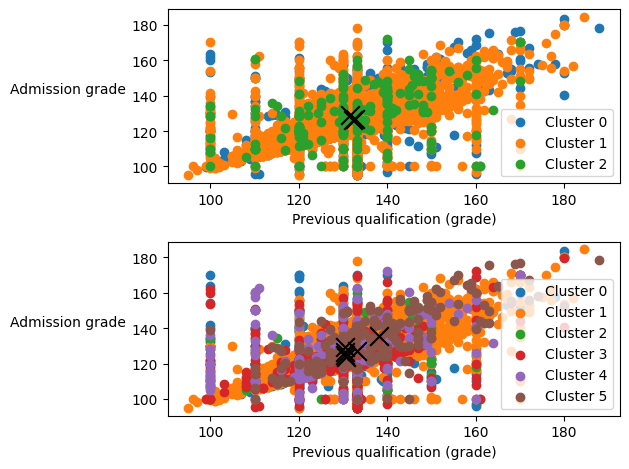

In [22]:
plot_models("Previous qualification (grade)", "Admission grade")

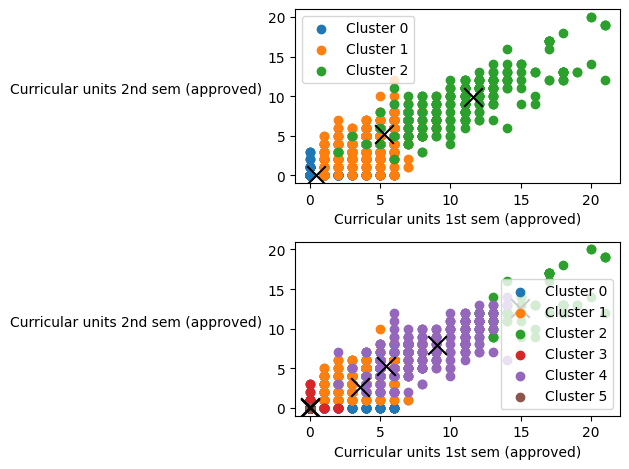

In [23]:
plot_models(
    "Curricular units 1st sem (approved)", "Curricular units 2nd sem (approved)"
)

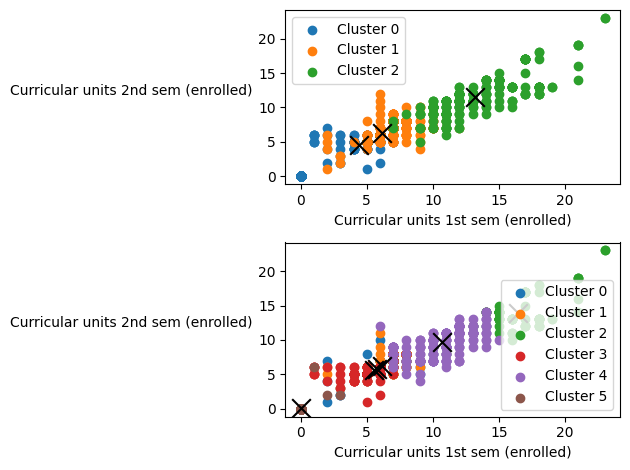

In [24]:
plot_models(
    "Curricular units 1st sem (enrolled)", "Curricular units 2nd sem (enrolled)"
)

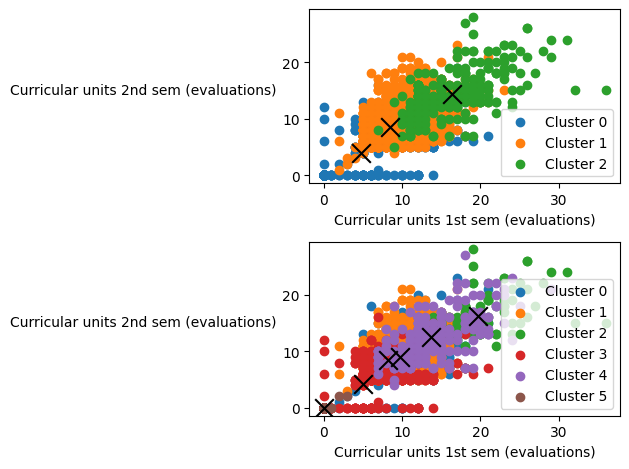

In [25]:
plot_models(
    "Curricular units 1st sem (evaluations)", "Curricular units 2nd sem (evaluations)"
)

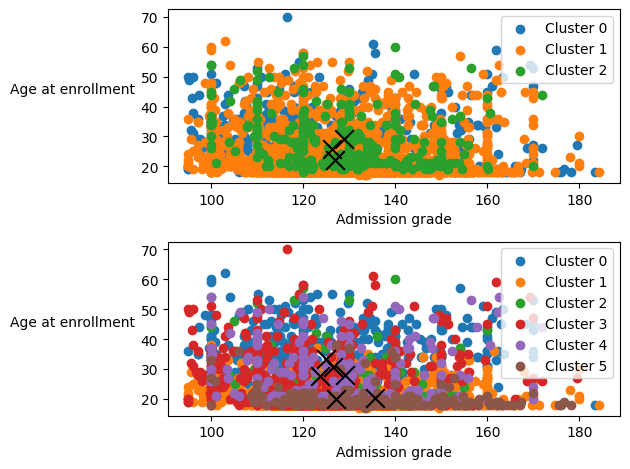

In [26]:
plot_models("Admission grade", "Age at enrollment")